# Heart Disease Prediction

## Introduction

Welcome to the Heart Disease Prediction notebook! In this session, we will explore a dataset related to heart disease and build a machine learning model to predict the likelihood of a patient having heart disease. 

## 1 Dataset Exploration and Understanding

To begin our journey, let's gain a thorough understanding of the dataset. We are dealing with a dataset that comprises 14 attributes, each providing valuable insights into a patient's health. From the patient's age and gender to specific medical indicators such as blood pressure and cholesterol levels, these attributes collectively form the basis for predicting heart disease.

###  1.1 Variable Information

Before diving into the analysis, let's understand the variables in our dataset:

1. Age (age): Patient's age in years.

2. Sex (sex): Gender of the patient.
    Values: 1 = Male, 0 = Female

3. Chest Pain Type (cp): Type of chest pain experienced.
    Values: 1 = Typical angina, 2 = Atypical angina, 3 = Non-anginal pain, 4 = Asymptomatic

4. Resting Blood Pressure (trestbps): Blood pressure on admission in mm Hg.

5. Serum Cholesterol (chol): Serum cholesterol level in mg/dl.

6. Fasting Blood Sugar (fbs): Fasting blood sugar level.
    Values: 1 = >120 mg/dl, 0 = <=120 mg/dl

7. Resting Electrocardiographic Results (restecg): Results of resting electrocardiogram.
    Values: 0 = Normal, 1 = ST-T wave abnormality, 2 = Probable or definite left ventricular hypertrophy

8. Maximum Heart Rate Achieved (thalach): Maximum heart rate during examination.

9. Exercise-Induced Angina (exang): Presence of exercise-induced angina.
    Values: 1 = Yes, 0 = No

10. ST Depression Induced by Exercise Relative to Rest (oldpeak): ST depression induced by exercise relative to rest.

11. Slope of the Peak Exercise ST Segment (slope): Slope of the peak exercise ST segment.
    Values: 1 = Upsloping, 2 = Flat, 3 = Downsloping

12. Number of Major Vessels Colored by Fluoroscopy (ca): Number of major vessels colored by fluoroscopy. A higher count may indicate a greater degree of vessel involvement or narrowing, which can be associated with more advanced stages of coronary artery disease.

13. Thalassemia (thal): Type of thalassemia.
    Values: 3 = Normal, 6 = Fixed defect, 7 = Reversible defect

14. Diagnosis of Heart Disease (num): Diagnosis based on angiographic disease status.
    Values: 0 = < 50% diameter narrowing, 1 = > 50% diameter narrowing (in any major vessel)

### 1.2 Dataset information: 
https://archive.ics.uci.edu/dataset/45/heart+disease


### 1.3 Introductory Paper

International application of a new probability algorithm for the diagnosis of coronary artery disease.
By R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sandhu, K. Guppy, S. Lee, V. Froelicher. 1989

Published in American Journal of Cardiology

### 1.4 Import Dataset and Libraries

In [1]:
# Install libraries
! pip install ucimlrepo
! pip install shap

In [2]:
# Import necessary libraries
import warnings
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
import shap

# Define color palette for plot
palette = ["#87CEEB", "#FFA07A"]

# Silence warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore",
                        message="is_categorical_dtype is deprecated")

In [3]:
# import dataset
heart_disease = fetch_ucirepo(name='Heart Disease')
df = heart_disease['data']['original'] # access data

# Print first 5 rows of our data
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


### 1.5 Feature Renaming

To enhance interpretability and align with medical terminology, we will rename the columns using more descriptive names. This not only makes the dataset more understandable but also improves the overall clarity of our analysis.

In [4]:
# Define a dictionary with the new column names
new_column_names = {
    'age': 'Age',
    'sex': 'Sex',
    'cp': 'ChestPainType',
    'trestbps': 'RestingBloodPressure',
    'chol': 'SerumCholesterol',
    'fbs': 'FastingBloodSugar',
    'restecg': 'RestingECG',
    'thalach': 'MaxHeartRate',
    'exang': 'ExerciseInducedAngina',
    'oldpeak': 'STDepression',
    'slope': 'SlopeSTSegment',
    'ca': 'NumMajorVessels',
    'thal': 'Thalassemia',
    'num': 'HeartDiseaseDiagnosis'
}

# Rename the columns using the dictionary
df.rename(columns=new_column_names, inplace=True)

# Print first 5 rows of our data
df.head()

,Age,Sex,ChestPainType,RestingBloodPressure,SerumCholesterol,FastingBloodSugar,RestingECG,MaxHeartRate,ExerciseInducedAngina,STDepression,SlopeSTSegment,NumMajorVessels,Thalassemia,HeartDiseaseDiagnosis
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


### 1.6 Target Binarization

In this step, we binarize the target variable, simplifying the problem into a binary classification task. Values greater than 0 are assigned 1, indicating a positive diagnosis, while values equal to 0 remain 0, signifying a negative diagnosis.

In [5]:
# Displaying the distribution of the original target variable (`HeartDiseaseDiagnosis`) provides insights into the balance between positive and negative diagnoses.
print('Before binarization: \n', df['HeartDiseaseDiagnosis'].value_counts())

# Binarize the target variable
df['HeartDiseaseDiagnosis'] = np.int64(df['HeartDiseaseDiagnosis'] > 0)
print('\nAfter binarization: \n', df['HeartDiseaseDiagnosis'].value_counts())


Before binarization: 
 HeartDiseaseDiagnosis
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

After binarization: 
 HeartDiseaseDiagnosis
0    164
1    139
Name: count, dtype: int64


Distribution After Binarization

Examining the distribution after binarization shows how the conversion has altered the balance between positive and negative diagnoses.

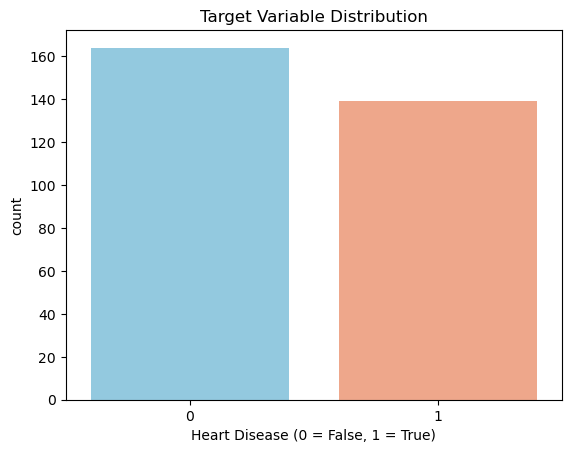

In [6]:
sns.countplot(x="HeartDiseaseDiagnosis", data=df, palette=palette)
plt.xlabel("Heart Disease (0 = False, 1 = True)")
plt.title('Target Variable Distribution')
plt.show()

### 1.7. Exploratory Data Analysis

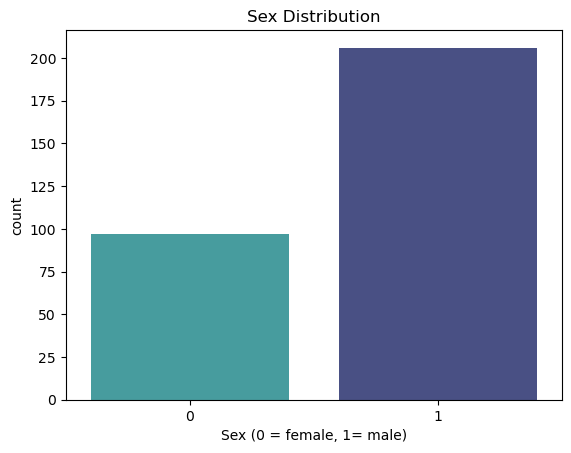

In [7]:
sns.countplot(x='Sex', data=df, palette="mako_r")
plt.xlabel("Sex (0 = female, 1= male)")
plt.title('Sex Distribution')
plt.show()

Text(0, 0.5, 'Frequency')

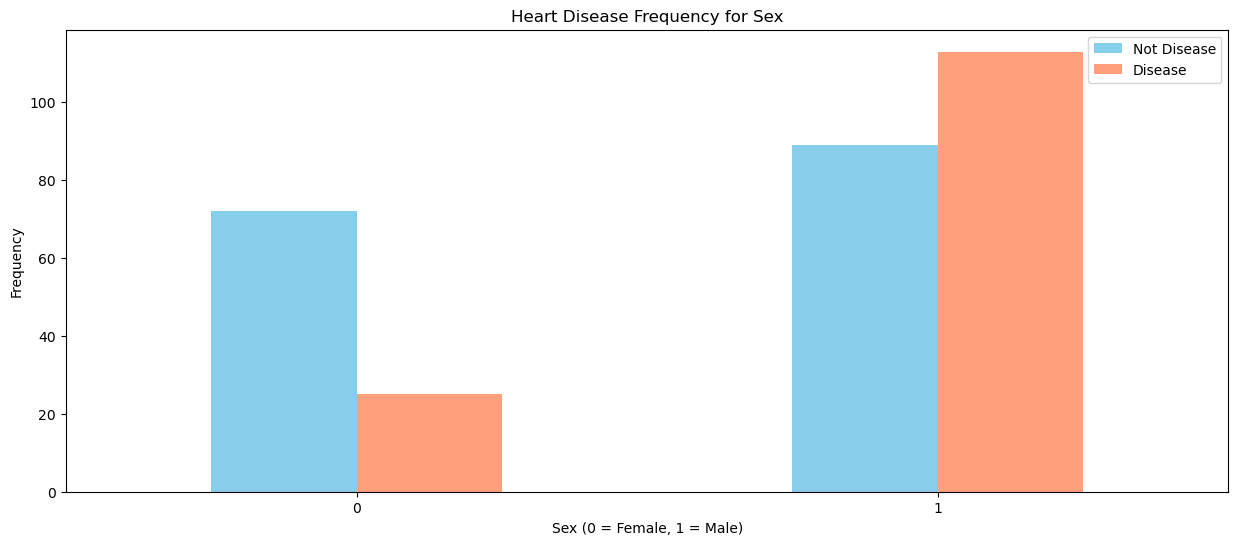

In [37]:
# Create a crosstab and plot the bar chart with the specified color palette
pd.crosstab(df.Sex, df.HeartDiseaseDiagnosis).plot(kind="bar", figsize=(15, 6), color=palette)

# Set the plot properties
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Not Disease", "Disease"]) 
plt.ylabel('Frequency')

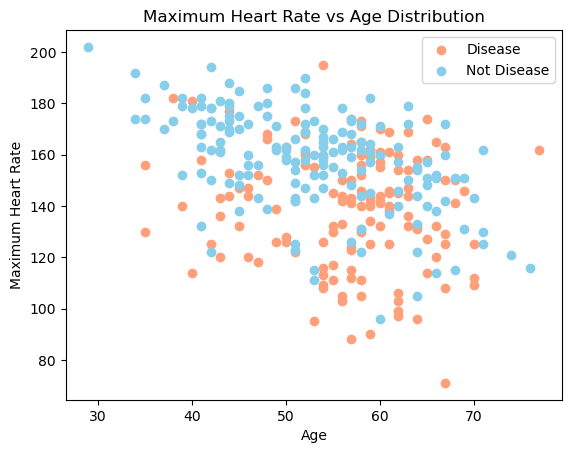

In [9]:
plt.scatter(x=df.Age[df.HeartDiseaseDiagnosis==1], y=df.MaxHeartRate[(df.HeartDiseaseDiagnosis==1)], c=palette[1])
plt.scatter(x=df.Age[df.HeartDiseaseDiagnosis==0], y=df.MaxHeartRate[(df.HeartDiseaseDiagnosis==0)], c=palette[0])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.title('Maximum Heart Rate vs Age Distribution')
plt.show()

#### Questions
Why is the target variable 'HeartDiseaseDiagnosis' binarized in the dataset?

    a) It simplifies the problem into a binary classification task.
    b) It makes the dataset more challenging.
    c) It allows for regression analysis.
    d) Binarization is a standard preprocessing step for all datasets.

After binarizing the 'HeartDiseaseDiagnosis' variable, what does a value of 1 represent?

    a) No heart disease
    b) Positive diagnosis of heart disease
    c) Missing data
    d) Uncertain diagnosis

## 2 Feature Preprocessing

### 2.1 Categorical Encoding

Let's replace numerical values in categorical features with corresponding extended description. For example 

Thalassemia has values 
- 3
- 6
- 7

They stand for:

- Normal (not thalassemia)
- Fixed defect (permanent)
- Reversible defect  (temporary)

In [10]:
# Define the mapping for each categorical variable
ChestPainType_mapping = {1: 'Typical angina', 2: 'Atypical angina', 3: 'Non-anginal pain', 4: 'Asymptomatic'}
Thalassemia_mapping = {3.0: 'Normal', 6.0: 'Fixed defect', 7.0: 'Reversible defect'}
SlopeSTSegment_mapping = {1: 'Upsloping', 2: 'Flat', 3: 'Downsloping'}
print('Before encoding:\n\n' ,df.Thalassemia.value_counts())

# Replace the values in the original DataFrame
df['ChestPainType'] = df['ChestPainType'].map(ChestPainType_mapping)
df['Thalassemia'] = df['Thalassemia'].map(Thalassemia_mapping)
df['SlopeSTSegment'] = df['SlopeSTSegment'].map(SlopeSTSegment_mapping)
print('After encoding:\n\n' ,df.Thalassemia.value_counts())


Before encoding:

 Thalassemia
3.0    166
7.0    117
6.0     18
Name: count, dtype: int64
After encoding:

 Thalassemia
Normal               166
Reversible defect    117
Fixed defect          18
Name: count, dtype: int64


Now that we have explicit names in the features, let's explore the distributions of the target for the different groups. That can help understand if a categorical variable could be relevant in the classification

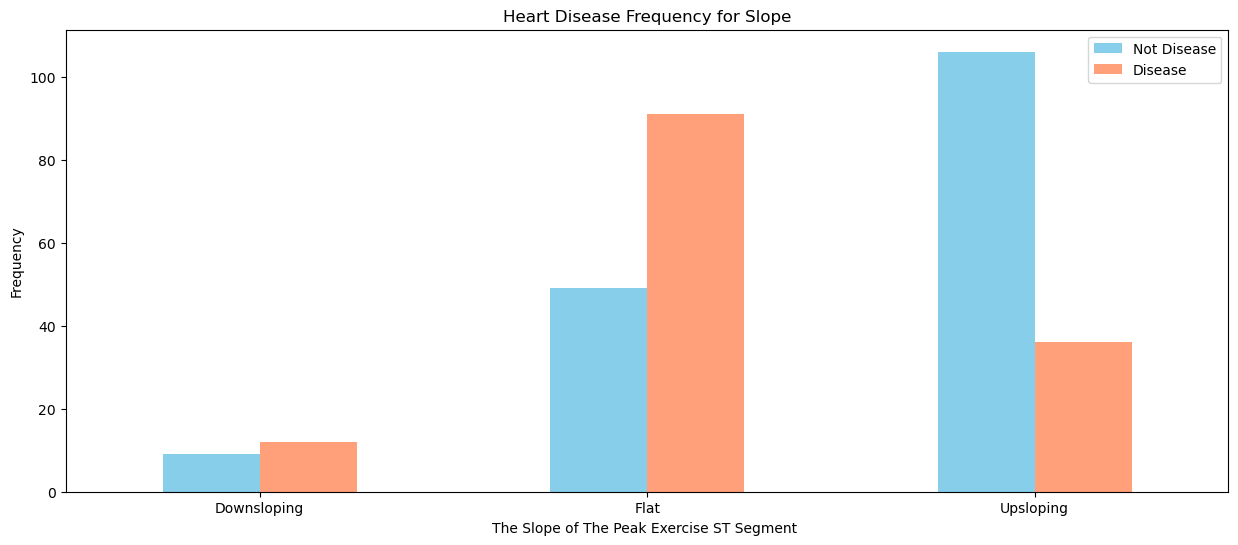

In [11]:
pd.crosstab(df.SlopeSTSegment,df.HeartDiseaseDiagnosis).plot(kind="bar",figsize=(15,6),color=palette)
plt.title('Heart Disease Frequency for Slope')
plt.xlabel('The Slope of The Peak Exercise ST Segment ')
plt.xticks(rotation = 0)
plt.legend(["Not Disease", "Disease"])
plt.ylabel('Frequency')
plt.show()

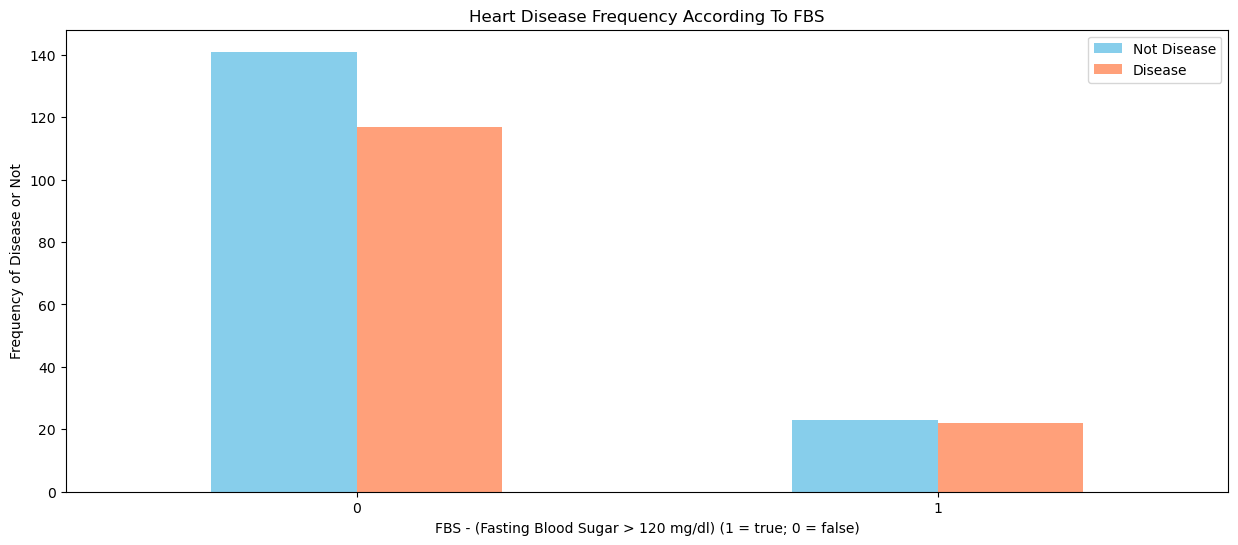

In [12]:
pd.crosstab(df.FastingBloodSugar,df.HeartDiseaseDiagnosis).plot(kind="bar",figsize=(15,6),color=palette)
plt.title('Heart Disease Frequency According To FBS')
plt.xlabel('FBS - (Fasting Blood Sugar > 120 mg/dl) (1 = true; 0 = false)')
plt.xticks(rotation = 0)
plt.legend(["Not Disease", "Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

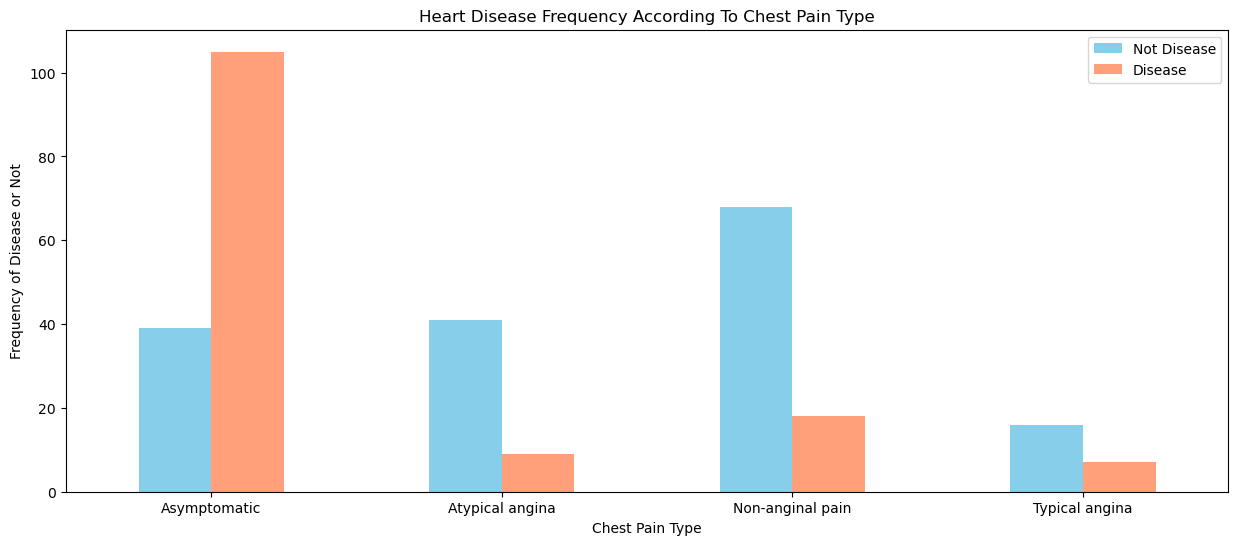

In [13]:
pd.crosstab(df.ChestPainType,df.HeartDiseaseDiagnosis).plot(kind="bar",figsize=(15,6),color=palette)
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.legend(["Not Disease", "Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

### Creating Dummy Variables

Since the selected features are categorical variables without a specific order, the optimal encoding method is one-hot encoding. For instance:

Instead of having a single variable for Thalassemia with multiple values (Normal, Fixed defect, Reversible defect), we create several variables with binary values (0 or 1).

    - Is the thalassemia the fixed defect type? (yes or no)
    - Is the thalassemia the reversible defect type? (yes or no)
    - Is the thalassemia not present (Normal)? (yes or no)

Since the conditions are mutually exclusive, only one feature of the three composing Thalassemia will be set to one.

Example:

    Normal -> 0, 0, 1

However, since observing the first two values allows us to deduce the third, these features become collinear. Therefore, to address this issue, one of the features must be dropped.

In [14]:
# Convert variables to appropriate data types
categorical_vars = ['ChestPainType', 'Thalassemia', 'SlopeSTSegment']
df[categorical_vars] = df[categorical_vars].astype(str)

In [15]:
df.replace('nan', np.nan, inplace=True)

In [16]:
# Use get_dummies and assign column names
dummies = pd.get_dummies(df[categorical_vars], prefix=categorical_vars,dummy_na = False, drop_first=True).astype(np.int64)
df = pd.concat([df, dummies], axis=1)
df = df.drop(columns=categorical_vars)

dummies

,ChestPainType_Atypical angina,ChestPainType_Non-anginal pain,ChestPainType_Typical angina,Thalassemia_Normal,Thalassemia_Reversible defect,SlopeSTSegment_Flat,SlopeSTSegment_Upsloping
0,0,0,1,0,0,0,0
1,0,0,0,1,0,1,0
2,0,0,0,0,1,1,0
3,0,1,0,1,0,0,0
4,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...
298,0,0,1,0,1,1,0
299,0,0,0,0,1,1,0
300,0,0,0,0,1,1,0
301,1,0,0,1,0,1,0


#### Questions:

In the dataset, which slope of the peak exercise ST segment (SlopeSTSegment) is associated with the least frequency of heart disease?

    a) Upsloping
    b) Downsloping
    c) Flat
    d) It is not mentioned in the dataset

Observing the chest pain types (ChestPainType), which type exhibits a behavior different from others in terms of heart disease frequency?

    a) Typical angina
    b) Atypical angina
    c) Non-anginal pain
    d) Asymptomatic

What does it signify if a certain chest pain type has a significantly higher frequency of heart disease in the dataset?

    a) The chest pain type might be an indicator of heart disease.
    b) The chest pain type is not relevant for predicting heart disease.
    c) It does not provide meaningful information about heart disease.

### 2.2 Missing values

In [17]:
# Check for missing values in all columns
missing_values = df.isna().sum()

# Display the count of missing values in each column
print(missing_values)

Age                               0
Sex                               0
RestingBloodPressure              0
SerumCholesterol                  0
FastingBloodSugar                 0
RestingECG                        0
MaxHeartRate                      0
ExerciseInducedAngina             0
STDepression                      0
NumMajorVessels                   4
HeartDiseaseDiagnosis             0
ChestPainType_Atypical angina     0
ChestPainType_Non-anginal pain    0
ChestPainType_Typical angina      0
Thalassemia_Normal                0
Thalassemia_Reversible defect     0
SlopeSTSegment_Flat               0
SlopeSTSegment_Upsloping          0
dtype: int64


In [18]:
df.dropna(inplace=True)
# Display the count of missing values in each column
missing_values = df.isna().sum()
print(missing_values)

Age                               0
Sex                               0
RestingBloodPressure              0
SerumCholesterol                  0
FastingBloodSugar                 0
RestingECG                        0
MaxHeartRate                      0
ExerciseInducedAngina             0
STDepression                      0
NumMajorVessels                   0
HeartDiseaseDiagnosis             0
ChestPainType_Atypical angina     0
ChestPainType_Non-anginal pain    0
ChestPainType_Typical angina      0
Thalassemia_Normal                0
Thalassemia_Reversible defect     0
SlopeSTSegment_Flat               0
SlopeSTSegment_Upsloping          0
dtype: int64


## 3 Model

### 3.1 Data Preparation for Machine Learning

**Separate Features and Target Variable**

The dataset is divided into features (X) and the target variable (y). Features (`X`) include all columns except for the target variable, while the target variable (`y`) is isolated.


In [19]:
# Separate features and target variable
X = df.drop('HeartDiseaseDiagnosis', axis=1)
y = df['HeartDiseaseDiagnosis']

**Perform Hold-out Split**

The dataset undergoes a hold-out split using train_test_split from scikit-learn. This partitions the data into training (X_train, y_train) and testing (X_test, y_test) sets, facilitating model training and evaluation. The test_size parameter is set to 0.2, meaning 80% of the data is used for training, and 20% of the data is reserved for testing the model.

In [20]:
# Perform a hold-out split (adjust test_size as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.2 Create and Train the Random Forest Model

Instantiate a Random Forest classifier with the specified hyperparameters and train the model using the training data.
Define hyperparameters for the Random Forest model. Students can experiment with and modify these values to observe their impact on model performance.


**max_depth**: Controls the maximum depth of each decision tree. A higher value captures more complex patterns but may lead to overfitting.

**n_estimators**: Sets the number of decision trees in the Random Forest ensemble. 

In [21]:
# Choose the hyperparameters for the model
#**********************************************************
max_depth = 10
n_estimators = 100
#**********************************************************

# Create and train the Random Forest model
model = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
trained_model = model.fit(X_train, y_train)
model

RandomForestClassifier(max_depth=10, random_state=42)

## 4 Model Evaluation and Visualization

### 4.0 Accuracy on train and test

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred = model.predict(X_test)
# Make predictions on the training set
y_pred_train = model.predict(X_train)


accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on train set: {accuracy_train:.2f}")

accuracy_test = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy_test:.2f}")

Accuracy on train set: 1.00
Accuracy on test set: 0.83


### 4.1 Confusion Matrix  

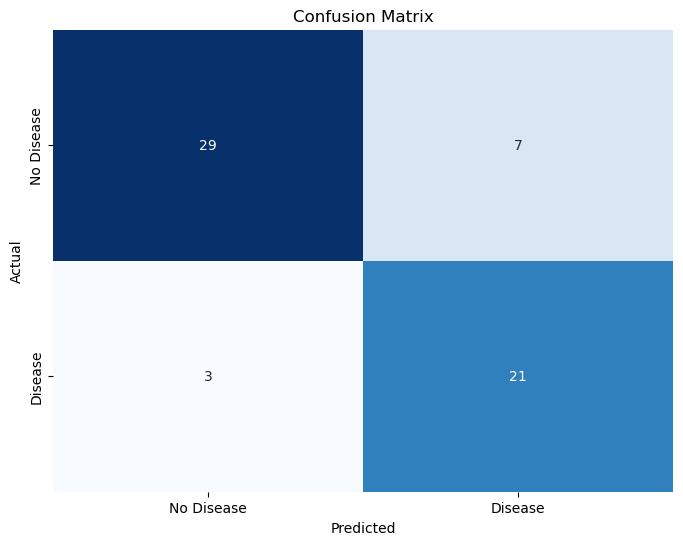

In [23]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 4.2 Classification Report and ROC Curve

Assess the model's classification performance using the classification report and visualize the Receiver Operating Characteristic (ROC) curve with the Area Under the Curve (AUC) score.

In [24]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.85        36
           1       0.75      0.88      0.81        24

    accuracy                           0.83        60
   macro avg       0.83      0.84      0.83        60
weighted avg       0.84      0.83      0.83        60



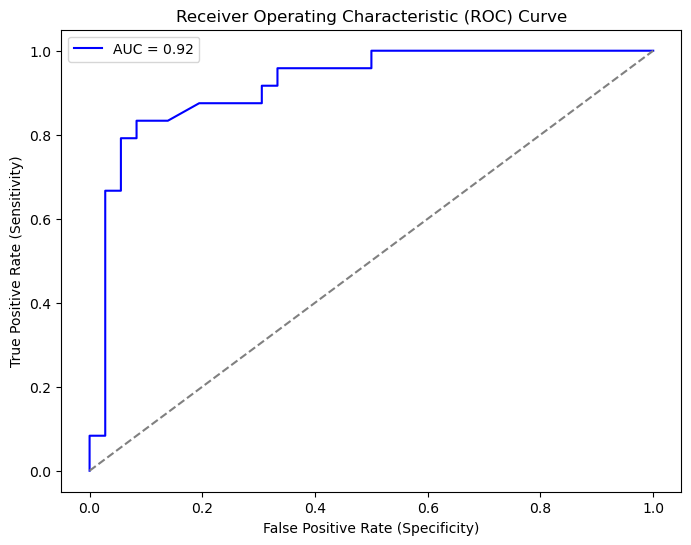

In [25]:
# Calculate AUC (Area Under the Curve)
y_probs = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probs)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.show()

#### Questions

When assessing a machine learning model's performance, which statement accurately describes the indication of overfitting based on the relationship between training and test accuracies?
    a) The model is overfitting if the training accuracy is significantly higher than the test accuracy.
    b) The model is overfitting if the test accuracy is significantly higher than the training accuracy.
    c) The model is not overfitting; the training and test accuracies are similar.
    d) The comparison of accuracies does not provide information about overfitting.

Given the comparison of training and test metrics for your machine learning model, analyze the following scenarios:

    A) The model is overfitting 
    B) The model is underfitting 
    C) The model is a good fit 
    D) It's not possible to say

Observing the confusion matrix, does the model have more false positives or false negatives? What implications does this imbalance have for the model's performance?

    a) More False Positives: The model is incorrectly predicting the absence of heart disease when it is actually present.
    b) More False Negatives: The model is incorrectly predicting the presence of heart disease when it is not actually present.
    c) Equal numbers of False Positives and False Negatives: The model is equally balanced.
    d) It is not specified in the confusion matrix.

## 5 Feature Importance Analysis and Interpretability

Feature Importance Analysis involves understanding which factors have the most influence on a predictive model's decisions. In clinical practice, these factors may represent crucial patient parameters, biomarkers, or clinical indicators.

**Importance in Clinical Practice**:
- Reliability: Identifying influential features enhances the reliability of diagnostic or predictive models.
- Interpretability: Knowing which factors matter most improves the interpretability of the model's decisions.
- Clinical Relevance: Provides actionable insights for healthcare professionals to focus on key factors in patient assessment.


### 5.1 Feature importance

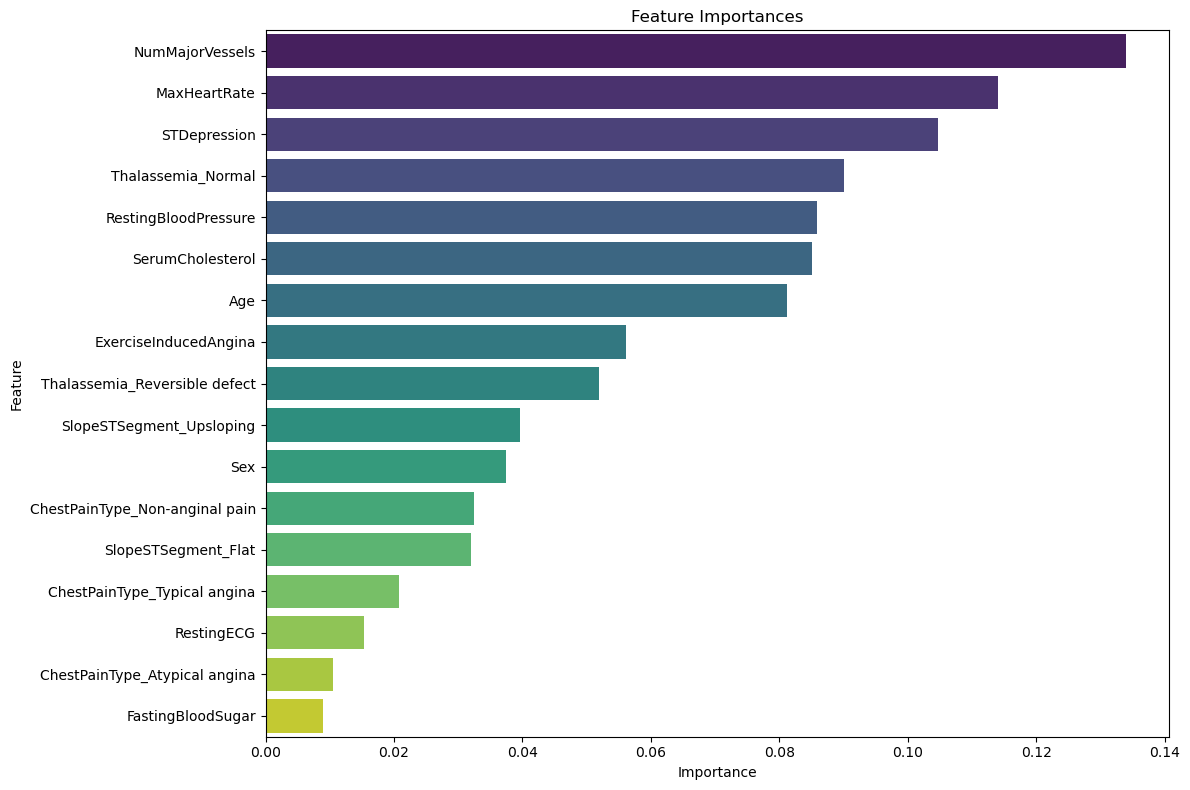

In [26]:
# Display feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': trained_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display feature importances with a bar plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()


To validate the reasonability of the feature importance analysis, let's conduct an exploratory analysis of the most relevant features. This additional investigation will provide insights into the patterns and characteristics of these features, helping us ensure their clinical relevance and alignment with our expectations.

In [27]:
df['NumMajorVessels'].value_counts()

NumMajorVessels
0.0    176
1.0     65
2.0     38
3.0     20
Name: count, dtype: int64

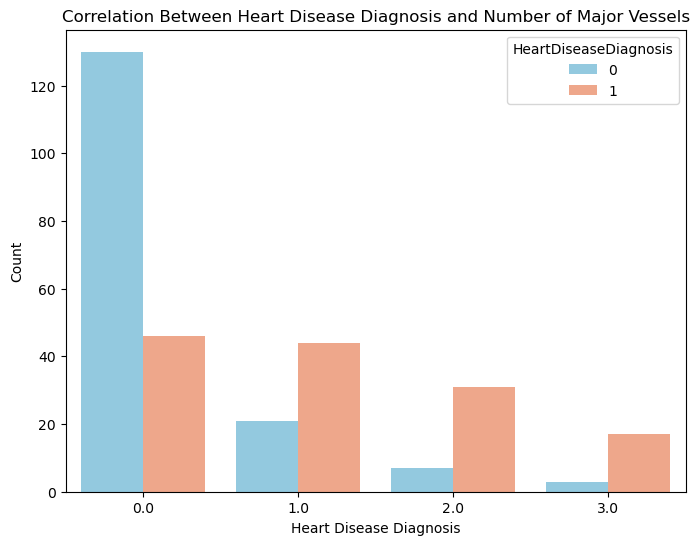

In [28]:
# Create a contingency table
contingency_table = pd.crosstab(df['HeartDiseaseDiagnosis'], df['NumMajorVessels'])

# Plot a stacked bar chart
plt.figure(figsize=(8, 6))
sns.countplot(x='NumMajorVessels', hue='HeartDiseaseDiagnosis', data=df, palette=palette)
plt.title('Correlation Between Heart Disease Diagnosis and Number of Major Vessels')
plt.xlabel('Heart Disease Diagnosis')
plt.ylabel('Count')
plt.show()


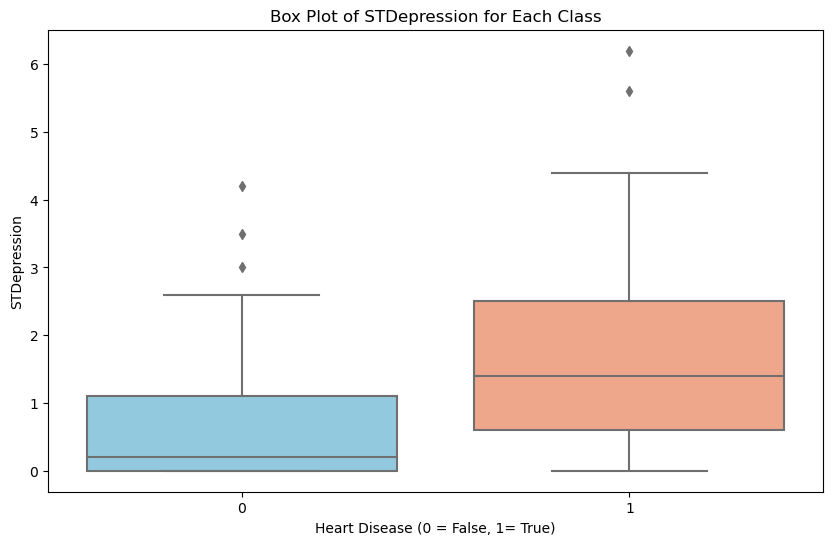

In [29]:
# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='HeartDiseaseDiagnosis', y='STDepression', data=df, palette=palette)

# Add labels and title
plt.xlabel('Heart Disease (0 = False, 1= True)')
plt.ylabel('STDepression')
plt.title('Box Plot of STDepression for Each Class')

# Show the plot
plt.show()

###  5.2 Further Interpretability Analysis

For a more in-depth validation, let's conduct further analysis using SHAP (SHapley Additive exPlanations). This approach will offer detailed insights into how each relevant feature contributes to individual model predictions, providing a robust understanding of the model's decision-making process and reinforcing the interpretability of our findings.

In [30]:
#**********************************************************
# choose the patient 
patient_number = 2
#**********************************************************

# load JS visualization code to notebook
shap.initjs()
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
# Force plot with custom colors
shap.force_plot(explainer.expected_value[1], shap_values[1][patient_number], X_test.iloc[patient_number, :], plot_cmap=palette[::-1])

In [31]:
patient_number = np.argmin(y_probs)
shap.initjs()
# Force plot with custom colors
shap.force_plot(explainer.expected_value[1], shap_values[1][patient_number], X_test.iloc[patient_number, :], plot_cmap=palette[::-1])

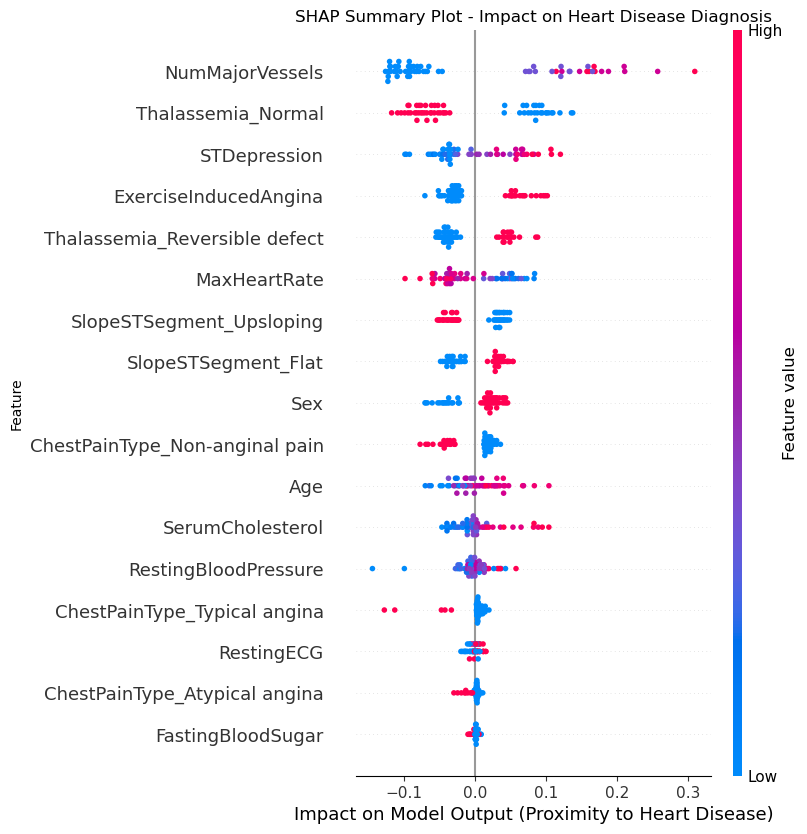

In [32]:
#Create a beeswarm plot to visualize the impact of features on predictions.
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, show=False)
plt.title("SHAP Summary Plot - Impact on Heart Disease Diagnosis")
plt.xlabel("Impact on Model Output (Proximity to Heart Disease)")
plt.ylabel("Feature")
plt.show()
plt.show()

Sex (sex): Gender of the patient. Values: 1 = Male, 0 = Female

Exercise-Induced Angina (exang): Presence of exercise-induced angina.
    Values: 1 = Yes, 0 = No

#### Questions

According to the feature importance analysis, which feature is identified as the most important for predicting heart disease?

        a) Age
        b) MaxHeartRate
        c) NumMajorVessels
        d) STDepression

Based on the contingency table and stacked bar chart for 'NumMajorVessels' and 'HeartDiseaseDiagnosis,' what trend can be observed regarding the number of major vessels and the presence of heart disease?

        a) As the number of major vessels increases, the likelihood of heart disease decreases.
        b) There is no correlation between the number of major vessels and the presence of heart disease.
        c) As the number of major vessels increases, the likelihood of heart disease increases.
        d) The trend is not specified in the analysis.

## Play with the model 



In [33]:
import ipywidgets as widgets
import pandas as pd
from IPython.display import display
from ipywidgets import Layout, Box
 
# Adjust the layout to ensure full descriptions are shown
style = {'description_width': 'initial'}
layout = Layout(width='50%')  # Adjust the width to fit your interface
 
# Create a dictionary to hold the widgets
input_widgets = {}
 
# Function to create input widgets with adjusted layout and style
def create_input_widgets():
    input_widgets['Age'] = widgets.IntSlider(min=0, max=100, value=50, description='Age', style=style, layout=layout)
    input_widgets['Sex'] = widgets.RadioButtons(options=[0, 1], description='Sex', style=style)
    input_widgets['RestingBloodPressure'] = widgets.IntSlider(min=80, max=200, value=120, description='Resting Blood Pressure', style=style, layout=layout)
    input_widgets['SerumCholesterol'] = widgets.IntSlider(min=100, max=600, value=200, description='Serum Cholesterol', style=style, layout=layout)
    input_widgets['FastingBloodSugar'] = widgets.RadioButtons(options=[0, 1], description='Fasting Blood Sugar', style=style)
    input_widgets['RestingECG'] = widgets.Dropdown(options=[0, 1, 2], description='Resting ECG Results', style=style, layout=layout)
    input_widgets['MaxHeartRate'] = widgets.IntSlider(min=60, max=200, value=100, description='Maximum Heart Rate', style=style, layout=layout)
    input_widgets['ExerciseInducedAngina'] = widgets.RadioButtons(options=[0, 1], description='Exercise Induced Angina', style=style)
    input_widgets['STDepression'] = widgets.FloatSlider(min=0, max=10.0, value=1.0, description='ST Depression', style=style, layout=layout)
    input_widgets['NumMajorVessels'] = widgets.Dropdown(options=[0.0, 1.0, 2.0, 3.0], description='Number of Major Vessels', style=style, layout=layout)
    input_widgets['ChestPainType_Atypical angina'] = widgets.RadioButtons(options=[0, 1], description='Chest Pain: Atypical Angina', style=style)
    input_widgets['ChestPainType_Non-anginal pain'] = widgets.RadioButtons(options=[0, 1], description='Chest Pain: Non-anginal Pain', style=style)
    input_widgets['ChestPainType_Typical angina'] = widgets.RadioButtons(options=[0, 1], description='Chest Pain: Typical Angina', style=style)
    input_widgets['Thalassemia_Normal'] = widgets.RadioButtons(options=[0, 1], description='Thalassemia: Normal', style=style)
    input_widgets['Thalassemia_Reversible defect'] = widgets.RadioButtons(options=[0, 1], description='Thalassemia: Reversible Defect', style=style)
    input_widgets['SlopeSTSegment_Flat'] = widgets.RadioButtons(options=[0, 1], description='Slope of ST Segment: Flat', style=style)
    input_widgets['SlopeSTSegment_Upsloping'] = widgets.RadioButtons(options=[0, 1], description='Slope of ST Segment: Upsloping', style=style)
 
    # Function to display widgets in a formatted way
    def display_widgets_in_box(widgets_dict):
        items = list(widgets_dict.values())
        box = Box(children=items, layout=Layout(
            display='flex',
            flex_flow='column',
            align_items='stretch',
            width='100%'
        ))
        display(box)
 
    display_widgets_in_box(input_widgets)
 
# Function to make prediction
def make_prediction(b):
    # Get the values from the widgets
    input_data = {name: widget.value for name, widget in input_widgets.items()}
   
    # Convert to DataFrame (assuming the model is trained with a DataFrame)
    input_df = pd.DataFrame(input_data, index=[0])
   
    # Make prediction
    prediction = model.predict(input_df)
   
    # Display the prediction
    print(f"Prediction: {prediction[0]}")
 
# Button to make prediction
predict_button = widgets.Button(description="Predict")
predict_button.on_click(make_prediction)
 
# Function to setup the interface
def setup_interface():
    create_input_widgets()
    display(predict_button)
 
# Call the function to setup the interface
setup_interface()


Box(children=(IntSlider(value=50, description='Age', layout=Layout(width='50%'), style=SliderStyle(description…

Button(description='Predict', style=ButtonStyle())